In [1]:
import os
import pandas as pd
import numpy as np
import pickle

from keras.models import Sequential
from keras.layers import *

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
plt.style.use('seaborn')

Using TensorFlow backend.


In [2]:
global_params = pickle.load(open("global_params.p", "rb"))
unique_words = global_params['unique_words']
num_words = global_params['num_words']
padded_length = global_params['padded_length']
n_classes = global_params['n_classes']
class_weights = global_params['class_weights']

global_params

{'unique_words': 277303,
 'num_words': 277304,
 'padded_length': 679,
 'n_classes': 6,
 'class_weights': array([ 1.26825655,  0.72736371,  0.27602776, 13.23801959, 30.29201502,
         9.49559404])}

In [3]:
X_train = np.load(os.path.join("data", "Kdata", "X_train.npy"))
y_train = np.load(os.path.join("data", "Kdata", "y_train.npy"))
X_val = np.load(os.path.join("data", "Kdata", "X_val.npy"))
y_val = np.load(os.path.join("data", "Kdata", "y_val.npy"))

In [4]:
from keras import backend as K

def macroPrec(y_true, y_pred):
    # a custom metric
    # note that any metric is computed per batch during training
    # (hence one needs large batches for it to make sense)
    # also, there is the implicit 0.5 treshold due to the round function
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    positives = K.sum(K.round(y_pred), axis=0)
    precision = true_positives / (positives + K.epsilon())

    macroPrec = K.mean( precision )
    
    return macroPrec

def macroRecall(y_true, y_pred):
    # a custom metric
    # note that any metric is computed per batch during training
    # (hence one needs large batches for it to make sense)
    # also, there is the implicit 0.5 treshold due to the round function
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    macroRecall = K.mean( recall )
    
    return macroRecall


def macroF1(y_true, y_pred):
    # a custom metric
    # note that any metric is computed per batch during training
    # (hence one needs large batches for it to make sense)
    # also, there is the implicit 0.5 treshold due to the round function
    
    def recall(y_true, y_pred):

        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
        actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
        recall = true_positives / (actual_ones + K.epsilon())
        return recall

    
    def precision(y_true, y_pred):
        
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
        positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)
        precision = true_positives / (positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    macroF1 = K.mean( 2*((precision*recall)/(precision+recall+K.epsilon())) )
    
    return macroF1


def fuzzy_macroF1_flip(y_true, y_pred):
    # a custom loss function
    # no clippping or rounding as those are not differentiable
    
    def recall(y_true, y_pred):

        true_positives = K.sum(y_true * y_pred, axis=0)
        actual_ones = K.sum(y_true, axis=0)
        recall = true_positives / (actual_ones + K.epsilon())
        return recall

    
    def precision(y_true, y_pred):
        
        true_positives = K.sum(y_true * y_pred, axis=0)
        positives = K.sum(y_pred, axis=0)
        precision = true_positives / (positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    macroF1 = K.mean( 2*((precision*recall)/(precision+recall+K.epsilon())) ) 
    
    return 1-macroF1

In [5]:
# auxiliary functions

# choose callback functions to be given in model.fit(...)
def callbacks(LRfactor=0.8):
    return [ReduceLROnPlateau(factor=LRfactor, patience = patience//4),
            EarlyStopping(monitor='val_macroF1', mode='max', patience=patience)
           ]

    
# to plot the learning history,
# i.e. loss and metrics on each train_batch and validation_batch
def plot_history(history):
    
    plt.figure(figsize=(18, 5))
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(loss) + 1)
    
    plt.subplot(1, 3, 1)    
    plt.plot(x, loss, 'ob', label='Training loss')
    plt.plot(x, val_loss, '-b', label='Validation loss')
    plt.title('Training and val losses') 
    plt.legend()
    
    all_metrics = np.array(list(set(history.history.keys()) - set(['loss', 'val_loss', 'lr'])))
    metrics = all_metrics[[not metric.startswith('val_') for metric in all_metrics]]
    plt.subplot(1, 3, 2)
    markers = ['b', 'r',  'g', 'y']
    marker = zip(markers, markers)
    for metric in metrics:
        results = history.history[metric]
        val_results = history.history['val_'+metric]
        mark1, mark2 = next(marker)
        plt.plot(x, results, 'o'+mark1, label=metric)
        plt.plot(x, val_results, '-'+mark2, label='Validation '+metric)
        plt.title('Training and val metrics')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    lr = history.history['lr'] # learning rate
    plt.plot(x, lr, 'k', label='Learning rate')
    plt.title('Learning rate')  
    plt.legend()

In [7]:
# some other global learning settings

batch_size = 3000
patience = 8
optimizer = 'adam' # 'rmsprop'
my_loss = fuzzy_macroF1_flip
my_metrics = [macroPrec, macroF1, macroRecall]

In [18]:
# the workhorse

class BlackBox():
    
    def __init__(self, layers, loss, metrics, callbacks=callbacks(), embedd = None, embedd_dims=[None]*3):
        
        self.layers = layers
        self.loss = loss
        self.metrics = metrics
        self.callbacks = callbacks
        self.history = None
        self.test_results = None
        
        self.model = Sequential()
        if embedd:
            self.input_dim = embedd_dims[0] # num_words
            self.output_dim = embedd_dims[1] # dimension of the embedding space
            self.input_length = embedd_dims[2] # padded_length
            self.embedd_weights = pickle.load(open(embedd, "rb"))
            
            self.model.add(Embedding(input_dim=self.input_dim,\
                                     output_dim=self.output_dim,\
                                     input_length=self.input_length,\
                                     weights=self.embedd_weights,\
                                     trainable=False))
        for layer in layers:
            self.model.add(layer)
            
        self.model.add(Dense(n_classes, activation='softmax'))
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=self.metrics)
    
    def summary(self):
        return self.model.summary()
    
    def fit(self, epochs=200):
        self.history = self.model.fit(
            X_train, y_train,
            class_weight=class_weights,
            epochs=epochs,
            batch_size=batch_size,
            #validation_split=0.1,
            validation_data=(X_val, y_val),
            callbacks=self.callbacks,
            verbose = 1        
            )
        
    def reset(self):
        
        self.history = None
        self.test_results = None
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=self.metrics)
        
    def evaluate(self, X_test, y_test):
        print(f'Loss function: {self.loss.__name__ if callable(self.loss) else self.loss}. Metrics: {[metric.__name__ if callable(metric) else metric for metric in self.metrics]}')
        print("Predicting for X_test, comparing with y_test")
        self.test_results = self.model.evaluate(X_test, y_test)
        return self.test_results
    
    def plot(self):
        plot_history(self.history)
        
    def save(self, file):
        self.model.save(file)
        
    def save_embedd(self, name):
        pickle.dump(self.model.layers[0].get_weights(), open(f"my_embedd_weights_{name}.p", "wb")) 
 


---

In [54]:
# training an embedding, test run

layers1 = [Embedding(input_dim=num_words, output_dim=50, input_length=padded_length, mask_zero=True),
           GlobalAveragePooling1D()]

model1 = BlackBox(layers=layers1, loss=my_loss, metrics=my_metrics)
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
global_average_pooling1d_5 ( (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 306       
Total params: 13,865,506
Trainable params: 13,865,506
Non-trainable params: 0
_________________________________________________________________


In [55]:
model1.fit()

Train on 500000 samples, validate on 200000 samples
Epoch 1/200
500000/500000 [==============================] - 237s 473us/step - loss: 0.8329 - macroPrec: 0.1121 - macroF1: 0.0696 - macroRecall: 0.0639 - val_loss: 0.7470 - val_macroPrec: 0.3222 - val_macroF1: 0.2462 - val_macroRecall: 0.2183
Epoch 2/200
500000/500000 [==============================] - 235s 471us/step - loss: 0.6560 - macroPrec: 0.4414 - macroF1: 0.3799 - macroRecall: 0.3547 - val_loss: 0.5944 - val_macroPrec: 0.4415 - val_macroF1: 0.4317 - val_macroRecall: 0.4225
Epoch 3/200
500000/500000 [==============================] - 240s 480us/step - loss: 0.5603 - macroPrec: 0.4438 - macroF1: 0.4368 - macroRecall: 0.4311 - val_loss: 0.5239 - val_macroPrec: 0.4815 - val_macroF1: 0.4424 - val_macroRecall: 0.4363
Epoch 4/200
500000/500000 [==============================] - 249s 498us/step - loss: 0.4633 - macroPrec: 0.7598 - macroF1: 0.5450 - macroRecall: 0.5064 - val_loss: 0.4021 - val_macroPrec: 0.8405 - val_macroF1: 0.6621 - 

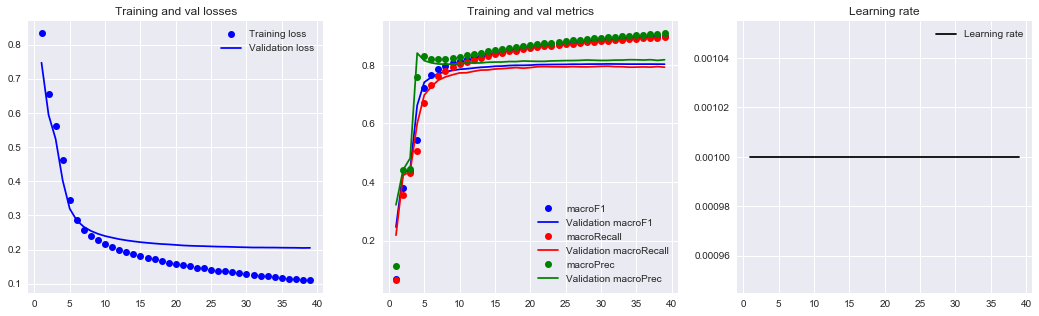

In [58]:
model1.plot()

In [56]:
model1.save('embedd_model1.h5')

In [57]:
model1.save_embedd("50dim_GlblAvg")

---

In [26]:
# training an embedding

layers2 = [Embedding(input_dim=num_words, output_dim=200, input_length=padded_length, mask_zero=True),
           GlobalAveragePooling1D()]

model2 = BlackBox(layers=layers2, loss=my_loss, metrics=my_metrics)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 679, 200)          55460800  
_________________________________________________________________
global_average_pooling1d_1 ( (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 1206      
Total params: 55,462,006
Trainable params: 55,462,006
Non-trainable params: 0
_________________________________________________________________


In [27]:
model2.fit()

Train on 500000 samples, validate on 200000 samples
Epoch 1/200
500000/500000 [==============================] - 958s 2ms/step - loss: 0.7725 - macroPrec: 0.2408 - macroF1: 0.1843 - macroRecall: 0.1709 - val_loss: 0.6184 - val_macroPrec: 0.4425 - val_macroF1: 0.4250 - val_macroRecall: 0.4094
Epoch 2/200
500000/500000 [==============================] - 952s 2ms/step - loss: 0.5389 - macroPrec: 0.5383 - macroF1: 0.4593 - macroRecall: 0.4442 - val_loss: 0.4455 - val_macroPrec: 0.8306 - val_macroF1: 0.5826 - val_macroRecall: 0.5329
Epoch 3/200
500000/500000 [==============================] - 948s 2ms/step - loss: 0.3453 - macroPrec: 0.8253 - macroF1: 0.7144 - macroRecall: 0.6658 - val_loss: 0.2944 - val_macroPrec: 0.8064 - val_macroF1: 0.7510 - val_macroRecall: 0.7156
Epoch 4/200
500000/500000 [==============================] - 944s 2ms/step - loss: 0.2593 - macroPrec: 0.8123 - macroF1: 0.7806 - macroRecall: 0.7587 - val_loss: 0.2583 - val_macroPrec: 0.7974 - val_macroF1: 0.7749 - val_macr

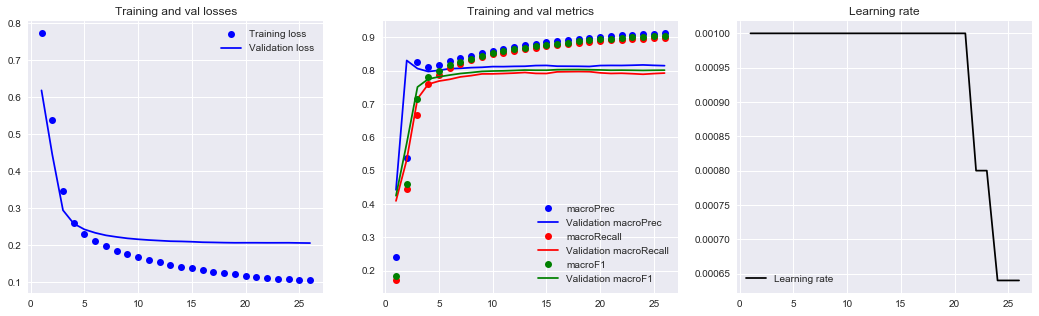

In [28]:
model2.plot()

In [29]:
model2.save('embedd_model2.h5')

In [30]:
model2.save_embedd("200dim_GlblAvg")

---

In [21]:
# training an embedding

layers3 = [Embedding(input_dim=num_words, output_dim=50, input_length=padded_length),
           Dropout(rate=0.5),
           AveragePooling1D(pool_size=3, strides=1, padding='valid', data_format='channels_last'),
           Flatten()
          ]

model3 = BlackBox(layers=layers3, loss=my_loss, metrics=my_metrics)
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
dropout_3 (Dropout)          (None, 679, 50)           0         
_________________________________________________________________
average_pooling1d_3 (Average (None, 677, 50)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 33850)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 203106    
Total params: 14,068,306
Trainable params: 14,068,306
Non-trainable params: 0
_________________________________________________________________


In [22]:
model3.fit()

Train on 500000 samples, validate on 200000 samples
Epoch 1/200
500000/500000 [==============================] - 600s 1ms/step - loss: 0.5624 - macroPrec: 0.4897 - macroF1: 0.4464 - macroRecall: 0.4365 - val_loss: 0.3587 - val_macroPrec: 0.7926 - val_macroF1: 0.6912 - val_macroRecall: 0.6524
Epoch 2/200
500000/500000 [==============================] - 639s 1ms/step - loss: 0.2542 - macroPrec: 0.8085 - macroF1: 0.7724 - macroRecall: 0.7526 - val_loss: 0.2315 - val_macroPrec: 0.8016 - val_macroF1: 0.7847 - val_macroRecall: 0.7734
Epoch 3/200
500000/500000 [==============================] - 651s 1ms/step - loss: 0.1927 - macroPrec: 0.8355 - macroF1: 0.8232 - macroRecall: 0.8156 - val_loss: 0.2182 - val_macroPrec: 0.8057 - val_macroF1: 0.7943 - val_macroRecall: 0.7871
Epoch 4/200
500000/500000 [==============================] - 654s 1ms/step - loss: 0.1675 - macroPrec: 0.8578 - macroF1: 0.8468 - macroRecall: 0.8398 - val_loss: 0.2137 - val_macroPrec: 0.8171 - val_macroF1: 0.7944 - val_macr

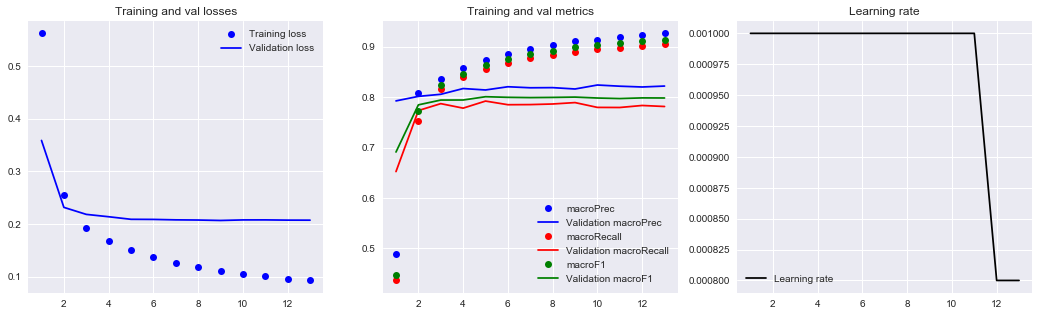

In [23]:
model3.plot()

In [24]:
model3.save('embedd_model3.h5')

In [25]:
model3.save_embedd("50dim_Drpt05_Avg3")

---